In [85]:
import csv
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import descartes
from shapely.geometry import Point, Polygon
#plot the poor housing conditions map
poorHouseCon = gpd.read_file('poorhousingcondition/Poor_Housing_Condition.shp')
poorHouseCon.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,TRACTCENUM,GEOIDNUM,TRACT,PPoorCon,geometry
0,42,003,431100,42003431100,4311,Census Tract 4311,431100.0,4.200343e+10,431100,0.022593,"POLYGON ((-80.04602 40.49487, -80.04553 40.494..."
1,42,003,432300,42003432300,4323,Census Tract 4323,432300.0,4.200343e+10,432300,0.015898,"POLYGON ((-80.06160 40.50581, -80.06160 40.505..."
2,42,003,563800,42003563800,5638,Census Tract 5638,563800.0,4.200356e+10,563800,0.016079,"POLYGON ((-80.12156 40.53626, -80.11346 40.533..."
3,42,003,563300,42003563300,5633,Census Tract 5633,563300.0,4.200356e+10,563300,0.018003,"POLYGON ((-80.13451 40.58823, -80.13282 40.587..."
4,42,003,451104,42003451104,4511.04,Census Tract 4511.04,451104.0,4.200345e+10,451104,0.009339,"POLYGON ((-80.24876 40.55465, -80.24825 40.554..."


In [86]:
#Load in the CSV Bike Station Location Data
df = pd.read_csv('HRSQ12020.csv')

#combine the latitude and longitude to make coordinates
df['coordinates'] = df[['Longitude', 'Latitude']].values.tolist()

# Change the coordinates to a geoPoint
df['coordinates'] = df['coordinates'].apply(Point)

#fixing wrong negative value for Latitude
df.loc[df["Latitude"] == df["Latitude"].min()]
df.at[80, 'Latitude'] = 40.467715

crs = {'init' :'epsg:4326'}
geometry = [Point(xy) for xy in zip(df.Longitude, df.Latitude)]
geobikes = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


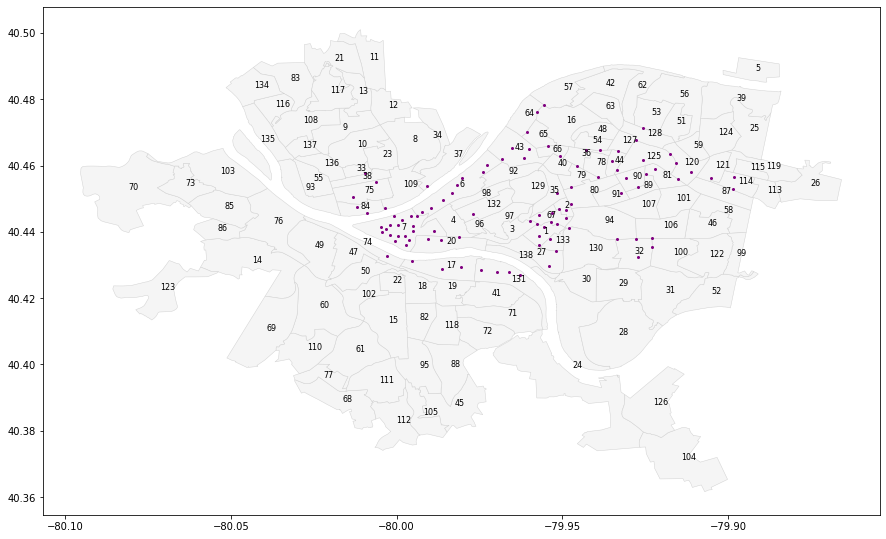

In [87]:
#get the 2010 census tract neighborhoods in Pittsburgh
cenTract = gpd.read_file('2010_Census_Tracts/a36fc9b1-4e53-4fd1-80fb-db1554e213422020328-1-nbfxcj.l6b8.shp')

#find the centroids of each neighborhood for labeling
cenTract["center"] = cenTract["geometry"].centroid
map_points = cenTract.copy()
map_points.set_geometry("center", inplace = True)
map_points.head()

#plot the neighborhood ids on the map
ax = cenTract.plot(figsize = (15, 12), color = "whitesmoke", edgecolor = "lightgrey", linewidth = 0.5)
texts = []

for x, y, label in zip(map_points.geometry.x, map_points.geometry.y, map_points["objectid"]):
    texts.append(plt.text(x, y, label, fontsize = 8))
    
#now adding the bike station location data on top of this map. 
#result = plt.scatter(df['Longitude'], df['Latitude'], 15, marker='o', color='Purple')
geobikes.plot(ax=ax, color="Purple", markersize=4);

#save figure and label it
resultFig = result.get_figure()
resultFig.savefig("result1.png")

In [88]:
#get only the poor housing condition rate to join to other data frame
poorCond_data = pd.DataFrame(poorHouseCon['PPoorCon'])
poorCond_data = poorCond_data.join(poorHouseCon['TRACTCE'])
poorCond_data = poorCond_data.rename(columns={'TRACTCE': 'tractce10'})

cenTract = cenTract.merge(poorCond_data, on="tractce10")
cenTract

,objectid,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,funcstat10,aland10,...,sum_lowmod,sum_lowm_1,lowmodperc,lowmodpe_1,cdbg2018,Shape__Are,Shape__Len,geometry,center,PPoorCon
0,1,42,003,040500,1,420030405001,Block Group 1,G5030,S,268195,...,2775,2985,92.964824,92.96,Yes,5.079492e+06,10442.036450,"POLYGON ((-79.95304 40.44203, -79.95302 40.442...",POINT (-79.95596 40.43963),0.000000
1,2,42,003,040400,1,420030404001,Block Group 1,G5030,S,75472,...,1365,2020,67.574257,67.57,Yes,2.105489e+06,6609.688123,"POLYGON ((-79.94727 40.44703, -79.94716 40.446...",POINT (-79.94942 40.44736),0.000000
2,3,42,003,040200,2,420030402002,Block Group 2,G5030,S,282679,...,1070,1290,82.945736,82.94,Yes,5.998649e+06,18280.484081,"POLYGON ((-79.96230 40.44294, -79.96220 40.442...",POINT (-79.96608 40.44023),0.037139
3,4,42,003,030500,2,420030305002,Block Group 2,G5030,S,284548,...,1635,2130,76.760563,76.76,Yes,7.203631e+06,15694.771444,"POLYGON ((-79.98275 40.44641, -79.98273 40.446...",POINT (-79.98379 40.44274),0.000000
4,5,42,003,980000,1,420039800001,Block Group 1,G5030,S,637235,...,65,220,29.545455,29.54,No,7.764866e+06,13581.875089,"POLYGON ((-79.88460 40.49066, -79.88451 40.486...",POINT (-79.89190 40.48871),0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,134,42,003,270100,2,420032701002,Block Group 2,G5030,S,604710,...,945,2475,38.181818,38.18,No,1.107355e+07,14197.343518,"POLYGON ((-80.03882 40.48725, -80.03805 40.487...",POINT (-80.04306 40.48362),0.000000
134,135,42,003,980900,1,420039809001,Block Group 1,G5030,S,1453388,...,0,0,0.000000,0,No,1.564899e+07,29884.799775,"MULTIPOLYGON (((-80.03668 40.47004, -80.03649 ...",POINT (-80.04117 40.46730),0.000000
135,136,42,003,250700,1,420032507001,Block Group 1,G5030,S,560320,...,555,765,72.549020,72.54,Yes,6.050817e+06,11709.518764,"POLYGON ((-80.02039 40.46285, -80.02022 40.462...",POINT (-80.02186 40.45994),0.054264
136,137,42,003,270400,1,420032704001,Block Group 1,G5030,S,395541,...,675,1035,65.217391,65.21,Yes,4.256393e+06,9062.212499,"POLYGON ((-80.02675 40.46778, -80.02665 40.467...",POINT (-80.02851 40.46541),0.028037


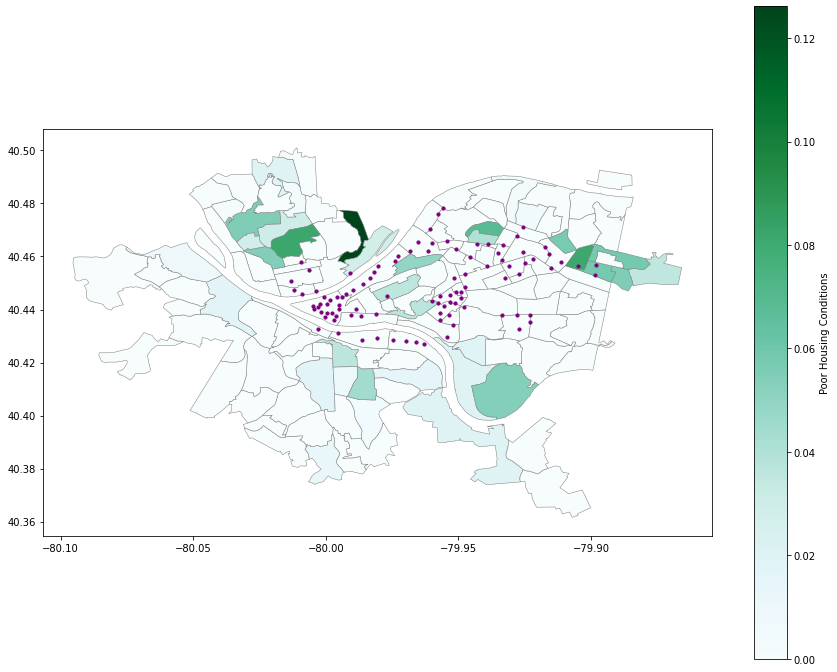

In [90]:
#plotting the poor housing condition data on the pittsburgh neighborhood map (data from 2016)
ax = cenTract.plot(column="PPoorCon", cmap='BuGn', figsize = (15, 12), edgecolor = "grey", linewidth = 0.5, legend=True, legend_kwds={'label': "Poor Housing Conditions",'orientation': "vertical"})
#now adding the bike station location data on top of this map. 
#result = plt.scatter(df['Longitude'], df['Latitude'], 15, marker='o', color='Purple')
geobikes.plot(ax=ax, color="Purple", markersize=10);

#save figure and label it
resultFig = result.get_figure()
resultFig.suptitle('Bike Station Location in Relation to Poor Housing Conditions: Pittsburgh, PA', fontsize=24)
resultFig.savefig("result.png")